In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/MyDrive/Skin Cancer')

['Train',
 'model.h5',
 'training_history.json',
 'nevus',
 'melanoma',
 'dermatofibroma']

In [ ]:
dataset = "/content/drive/My Drive/Skin Cancer/Train"

class_count = {}

for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)

    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path)])
        class_count[class_name] = num_images

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

df = pd.DataFrame(list(class_count.items()), columns=['Type', 'Count'])
df.sort_values(by='Count', ascending=False, inplace=True)
print("Total Images: ", df['Count'].sum())
print(df)

Total Images:  2256
                         Type  Count
1  pigmented benign keratosis    462
2                    melanoma    438
5        basal cell carcinoma    376
7                       nevus    367
8     squamous cell carcinoma    181
3             vascular lesion    146
4           actinic keratosis    114
6              dermatofibroma     95
0        seborrheic keratosis     77


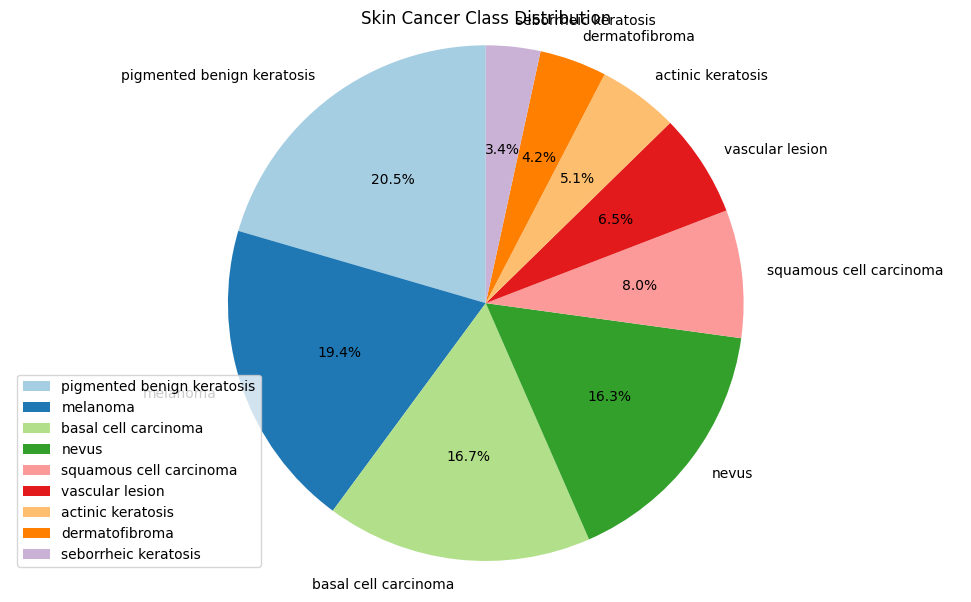

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.pie(df['Count'], labels=df['Type'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Skin Cancer Class Distribution")
plt.legend(loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
def process_and_resize_images(main_directory, size=(150, 150)):
    image_data = {}

    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path):
            image_data[subdir] = []

            for filename in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, filename)

                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    try:
                        image = Image.open(file_path)
                        resized_image = image.resize(size)
                        image_np = np.asarray(resized_image)
                        image_data[subdir].append(image_np)
                        resized_image.save(file_path)

                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

    return image_data

In [ ]:
main_directory = "/content/drive/My Drive/Skin Cancer/Train"
image_dict = process_and_resize_images(main_directory)

for subdir, images in image_dict.items():
    print(f"Subdirectory: {subdir}, Number of images: {len(images)}")

Subdirectory: seborrheic keratosis, Number of images: 77
Subdirectory: pigmented benign keratosis, Number of images: 462
Subdirectory: melanoma, Number of images: 438
Subdirectory: vascular lesion, Number of images: 146
Subdirectory: actinic keratosis, Number of images: 114
Subdirectory: basal cell carcinoma, Number of images: 376
Subdirectory: dermatofibroma, Number of images: 95
Subdirectory: nevus, Number of images: 367
Subdirectory: squamous cell carcinoma, Number of images: 181


In [ ]:
from PIL import Image

def create_image_dataframe(dataset_path):
    data = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)

                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    try:
                        image = Image.open(file_path)
                        image_np = np.asarray(image)
                        data.append((file_path, class_name, image_np))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    df = pd.DataFrame(data, columns=['image_path', 'type', 'image'])
    return df

In [ ]:
import pandas as pd

dataset_path = "/content/drive/My Drive/Skin Cancer/Train"
df = create_image_dataframe(dataset_path)
df.head(5)

,image_path,type,image
0,/content/drive/My Drive/Skin Cancer/Train/sebo...,seborrheic keratosis,"[[[184, 171, 163], [183, 170, 162], [183, 170,..."
1,/content/drive/My Drive/Skin Cancer/Train/sebo...,seborrheic keratosis,"[[[184, 163, 142], [185, 164, 143], [187, 166,..."
2,/content/drive/My Drive/Skin Cancer/Train/sebo...,seborrheic keratosis,"[[[197, 194, 179], [194, 191, 176], [191, 188,..."
3,/content/drive/My Drive/Skin Cancer/Train/sebo...,seborrheic keratosis,"[[[153, 142, 110], [154, 143, 111], [155, 144,..."
4,/content/drive/My Drive/Skin Cancer/Train/sebo...,seborrheic keratosis,"[[[191, 183, 164], [195, 187, 168], [197, 186,..."


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
import tensorflow as tf

def augment_images(df, datagen, target_count=2500):
    augmented_df = []

    for class_label in df['type'].unique():
        image_arrays = df.loc[df['type'] == class_label, 'image'].values
        num_needed = target_count - len(image_arrays)

        if num_needed > 0:
            selected_images = np.random.choice(image_arrays, size=num_needed, replace=True)

            for image_array in selected_images:
                tensor_image = tf.expand_dims(image_array, axis=0)
                augmented_images = datagen.flow(tensor_image, batch_size=1)

                for _ in range(augmented_images.n):
                    augmented_image_array = next(augmented_images)[0].astype(np.uint8)
                    augmented_df.append({'image_path': None, 'type': class_label, 'image': augmented_image_array})

        original_images = df.loc[df['type'] == class_label, ['image_path', 'type', 'image']].to_dict(orient='records')
        augmented_df.extend(original_images)

    augmented_df = pd.DataFrame(augmented_df)
    return augmented_df.groupby('type').head(target_count)

df = augment_images(df, datagen)

In [ ]:
df

,image_path,type,image
0,None,seborrheic keratosis,"[[[214, 206, 193], [214, 206, 193], [214, 206,..."
1,None,seborrheic keratosis,"[[[129, 88, 82], [129, 88, 82], [129, 88, 82],..."
2,None,seborrheic keratosis,"[[[218, 212, 214], [218, 212, 214], [218, 212,..."
3,None,seborrheic keratosis,"[[[197, 179, 169], [197, 179, 169], [197, 179,..."
4,None,seborrheic keratosis,"[[[168, 122, 104], [168, 126, 104], [171, 130,..."
...,...,...,...
22495,/content/drive/My Drive/Skin Cancer/Train/squa...,squamous cell carcinoma,"[[[232, 189, 198], [235, 192, 199], [239, 194,..."
22496,/content/drive/My Drive/Skin Cancer/Train/squa...,squamous cell carcinoma,"[[[88, 58, 68], [97, 67, 77], [113, 83, 95], [..."
22497,/content/drive/My Drive/Skin Cancer/Train/squa...,squamous cell carcinoma,"[[[153, 102, 99], [160, 109, 106], [168, 115, ..."
22498,/content/drive/My Drive/Skin Cancer/Train/squa...,squamous cell carcinoma,"[[[219, 192, 183], [221, 194, 185], [224, 197,..."


In [ ]:
image_index = df.groupby('type').size()
print(image_index)

type
actinic keratosis             2500
basal cell carcinoma          2500
dermatofibroma                2500
melanoma                      2500
nevus                         2500
pigmented benign keratosis    2500
seborrheic keratosis          2500
squamous cell carcinoma       2500
vascular lesion               2500
dtype: int64


In [ ]:
df['type_ind'] = pd.Categorical(df['type']).codes
print(df)

                                              image_path  \
0                                                   None   
1                                                   None   
2                                                   None   
3                                                   None   
4                                                   None   
...                                                  ...   
22495  /content/drive/My Drive/Skin Cancer/Train/squa...   
22496  /content/drive/My Drive/Skin Cancer/Train/squa...   
22497  /content/drive/My Drive/Skin Cancer/Train/squa...   
22498  /content/drive/My Drive/Skin Cancer/Train/squa...   
22499  /content/drive/My Drive/Skin Cancer/Train/squa...   

                          type  \
0         seborrheic keratosis   
1         seborrheic keratosis   
2         seborrheic keratosis   
3         seborrheic keratosis   
4         seborrheic keratosis   
...                        ...   
22495  squamous cell carcinoma   
22496  

In [ ]:
features = df.drop(columns = ['type_ind', 'type', 'image_path'], axis = 1)
target = df['type_ind']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True)

In [ ]:
import numpy as np

def compute_mean_std(images, batch_size=128):
    """ Compute mean and std in smaller batches to prevent memory overflow. """
    mean_sum, std_sum, count = 0.0, 0.0, 0

    for i in range(0, len(images), batch_size):
        batch = np.array(images[i:i + batch_size].tolist(), dtype=np.float32)
        batch_mean = np.mean(batch)
        batch_std = np.std(batch)

        mean_sum += batch_mean * len(batch)
        std_sum += batch_std * len(batch)
        count += len(batch)

    mean = mean_sum / count
    std = std_sum / count

    return mean, std

def normalize_batches(images, mean, std, batch_size=128):
    """ Normalize images in smaller batches to further reduce memory usage. """
    for i in range(0, len(images), batch_size):
        batch = np.array(images[i:i + batch_size].tolist(), dtype=np.float32)
        batch = (batch - mean) / std
        yield batch  # Yield normalized batch instead of storing everything

# Compute mean and std with smaller batch size
X_train_mean, X_train_std = compute_mean_std(X_train['image'], batch_size=128)
X_test_mean, X_test_std = compute_mean_std(X_test['image'], batch_size=128)

# Normalize using smaller batch size
X_train_generator = normalize_batches(X_train['image'], X_train_mean, X_train_std, batch_size=128)
X_test_generator = normalize_batches(X_test['image'], X_test_mean, X_test_std, batch_size=128)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes = 9)
y_test = to_categorical(y_test,num_classes = 9)

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True)

In [ ]:
X_train = np.array(X_train['image'].tolist())
X_test = np.array(X_test['image'].tolist())
X_validate = np.array(X_validate['image'].tolist())

X_train = X_train.reshape(X_train.shape[0], 150, 150, 3)
X_test = X_test.reshape(X_test.shape[0], 150, 150, 3)
X_validate = X_validate.reshape(X_validate.shape[0], 150, 150, 3)

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [ ]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)

for _, row in df.drop_duplicates(subset=["type"]).iterrows():
    class_label = row["type_ind"]
    class_name = row["type"]

    train_num = int(train_counts[class_label]) if class_label < len(train_counts) else 0
    val_num = int(val_counts[class_label]) if class_label < len(val_counts) else 0
    test_num = int(test_counts[class_label]) if class_label < len(test_counts) else 0
    total_num = train_num + val_num + test_num

    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")

print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
6               seborrheic keratosis           1591       382          527        2500      
5               pigmented benign keratosis     1578       445          477        2500      
3               melanoma                       1599       406          495        2500      
8               vascular lesion                1610       404          486        2500      
0               actinic keratosis              1596       405          499        2500      
1               basal cell carcinoma           1620       398          482        2500      
2               dermatofibroma                 1632       369          499        2500      
4               nevus                          1552       

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

base_model = keras.applications.ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from keras import Sequential

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(9, activation = "softmax")
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,807,241 (190.00 MB)

 Trainable params: 49,754,121 (189.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

In [ ]:
opt = SGD(learning_rate = 0.001, momentum=0.9)

model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    verbose = 1,
    factor = 0.5,
    patience = 3,
    min_lr = 0.00001
)

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_validate, y_validate),
    callbacks = [learning_rate_reduction]
)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 130s 191ms/step - accuracy: 0.4742 - loss: 1.7485 - val_accuracy: 0.6483 - val_loss: 0.8714 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 113s 172ms/step - accuracy: 0.7520 - loss: 0.6478 - val_accuracy: 0.7111 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8459 - loss: 0.4029 - val_accuracy: 0.7739 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.8962 - loss: 0.2753 - val_accuracy: 0.7178 - val_loss: 0.8062 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9228 - loss: 0.2106 - val_accuracy: 0.8194 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9395 - loss: 0.1684 - val_accuracy: 0.7478 - val_loss: 0.8162 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0

In [ ]:
model.save("/content/drive/MyDrive/Skin Cancer/model.h5")

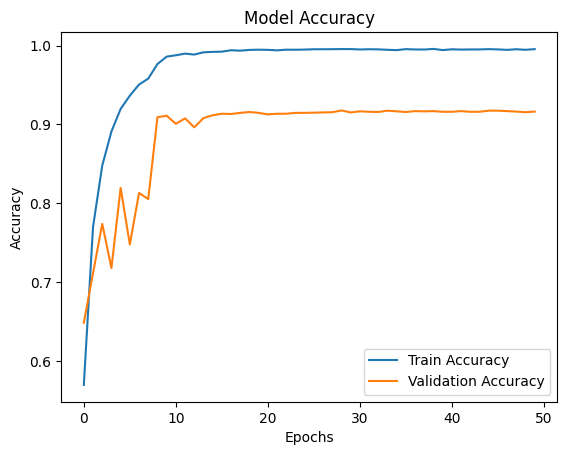

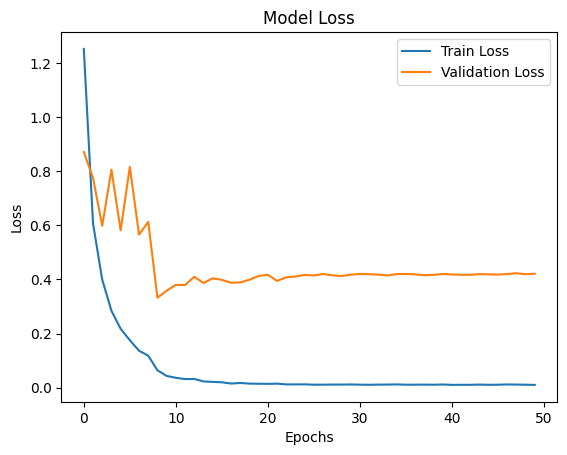

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
import json

history_dict = history.history  # Extract training history

with open("/content/drive/MyDrive/Skin Cancer/training_history.json", "w") as f:
    json.dump(history_dict, f)  # Save as JSON


In [ ]:
import os
os.listdir('/content/drive/MyDrive/Skin Cancer')

['Train', 'model.h5', 'training_history.json']

In [ ]:
with open("/content/drive/MyDrive/Skin Cancer/training_history.json", "r") as f:
    history_dict = json.load(f)

# Print all keys (metrics recorded during training)
print("Training History Keys:", history_dict.keys())

# Print full training details
for key, values in history_dict.items():
    print(f"{key}: {values[-1:]} ...")

Training History Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
accuracy: [0.9956250190734863] ...
loss: [0.009814559482038021] ...
val_accuracy: [0.9163888692855835] ...
val_loss: [0.4212753176689148] ...
learning_rate: [9.999999747378752e-06] ...


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load saved model
model = load_model("/content/drive/MyDrive/Skin Cancer/model.h5")

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step


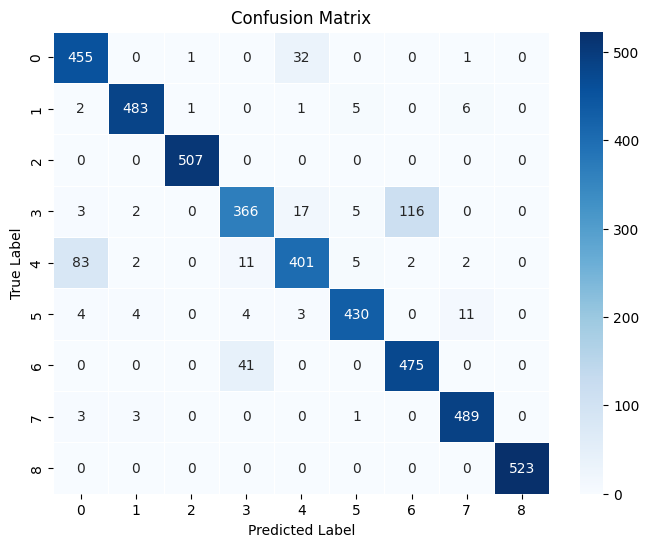

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix without exponential notation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9284
Precision: 0.9283
Recall: 0.9269
F1-score: 0.9266
Kappa score: 0.9195


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define the mapping of class indices to skin cancer types
CLASS_MAPPING = {
    5: "pigmented benign keratosis",
    3: "melanoma",
    1: "basal cell carcinoma",
    4: "nevus",
    7: "squamous cell carcinoma",
    8: "vascular lesion",
    0: "actinic keratosis",
    2: "dermatofibroma",
    6: "seborrheic keratosis"
}

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Skin Cancer/model.h5")

# Load and preprocess a single image
img_path = "/content/drive/MyDrive/Skin Cancer/nevus/ISIC_0000017.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(150, 150))  # Adjust size based on model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
y_pred_probs = model.predict(img_array)
y_pred = np.argmax(y_pred_probs, axis=1)[0]
class_name = CLASS_MAPPING.get(y_pred, "Unknown")

print("Predicted Class Index:", y_pred)
print("Predicted Class Name:", class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class Index: 4
Predicted Class Name: nevus


In [ ]:
import tensorflow as tf

# Load the trained model
model_path = "/content/drive/MyDrive/Skin Cancer/model.h5"
model = tf.keras.models.load_model(model_path)

# Print model summary
model.summary()

# Check if model is correctly compiled
print(f"Loss function: {model.loss}")
print(f"Metrics: {model.metrics}")

# Inspect weights of the final layer
weights, biases = model.layers[-1].get_weights()
print(f"Final layer weights shape: {weights.shape}")
print(f"Final layer biases: {biases}")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,807,243 (190.00 MB)

 Trainable params: 49,754,121 (189.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

Loss function: <function categorical_crossentropy at 0x7c52dae216c0>
Metrics: [<Mean name=loss>, <CompileMetrics name=compile_metrics>]
Final layer weights shape: (512, 9)
Final layer biases: [ 0.00353547  0.00869783 -0.01423535  0.00263524  0.00665461  0.01305125
 -0.00241681  0.01715287 -0.03507491]
